In [1]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [2]:
def read_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df


In [3]:
filepath_std_1990 = "../database/features/norm_2048_nfft_1024_hop_40_mfcc.csv"
filepath_1990 = "../database/features/2048_nfft_1024_hop_40_mfcc.csv"

target_dict = {'happy': 0, 'angry': 1, 'sad': 2, 'relaxed': 3}

In [4]:
df = read_data(filepath_std_1990)

df.replace({"emotion": target_dict}, inplace=True)

## Columns:

In [5]:
for i, col in enumerate(df.columns):
    print(i, col)

0 zcr_mean
1 zcr_std
2 rms_mean
3 rms_std
4 tempo
5 cent_mean
6 cent_std
7 rolloff_mean
8 rolloff_std
9 flatness_mean
10 flatness_std
11 mfccs_mean_21ms_0
12 mfccs_mean_21ms_1
13 mfccs_mean_21ms_2
14 mfccs_mean_21ms_3
15 mfccs_mean_21ms_4
16 mfccs_mean_21ms_5
17 mfccs_mean_21ms_6
18 mfccs_mean_21ms_7
19 mfccs_mean_21ms_8
20 mfccs_mean_21ms_9
21 mfccs_mean_21ms_10
22 mfccs_mean_21ms_11
23 mfccs_mean_21ms_12
24 mfccs_mean_21ms_13
25 mfccs_mean_21ms_14
26 mfccs_mean_21ms_15
27 mfccs_mean_21ms_16
28 mfccs_mean_21ms_17
29 mfccs_mean_21ms_18
30 mfccs_mean_21ms_19
31 mfccs_mean_21ms_20
32 mfccs_mean_21ms_21
33 mfccs_mean_21ms_22
34 mfccs_mean_21ms_23
35 mfccs_mean_21ms_24
36 mfccs_mean_21ms_25
37 mfccs_mean_21ms_26
38 mfccs_mean_21ms_27
39 mfccs_mean_21ms_28
40 mfccs_mean_21ms_29
41 mfccs_mean_21ms_30
42 mfccs_mean_21ms_31
43 mfccs_mean_21ms_32
44 mfccs_mean_21ms_33
45 mfccs_mean_21ms_34
46 mfccs_mean_21ms_35
47 mfccs_mean_21ms_36
48 mfccs_mean_21ms_37
49 mfccs_mean_21ms_38
50 mfccs_mean_21ms

In [6]:
df_all_X = df.iloc[:, :-1]

df_X_chroma = df_all_X.iloc[:, 265:289]

df_X_contrast = df_all_X.iloc[:, 251:265]

df_X_MFCC_21ms_40 = df_all_X.iloc[:, 11:91]

df_X_MFCC_21ms_40_contrast = pd.concat([df_X_MFCC_21ms_40, df_X_contrast], axis=1)

df_X_MFCC_21ms_1s_30s =  df_all_X.iloc[:, 11:251]

df_X_spectral = pd.concat([df_X_contrast, df_all_X.iloc[:, 5:11]], axis=1)

df_X_ZCR_RMS_spectral = pd.concat([df_X_spectral, df_all_X.iloc[:, 0:4]], axis=1)

df_X_ZCR_RMS_spectral_choosen = pd.concat([df_X_ZCR_RMS_spectral, df_all_X.iloc[:, 5:11]], axis=1)

df_X_MFCC_choosen = pd.concat([df_all_X.iloc[:, 11], df_all_X.iloc[:, 51], df_all_X.iloc[:, 39], df_all_X.iloc[:, 79], df_all_X.iloc[:, 49:51], df_all_X.iloc[:, 89:91]], axis=1)

df_X_MFCC_feature_importance = pd.concat([df_X_MFCC_21ms_40.iloc[:, 2], df_X_MFCC_21ms_40.iloc[:, 18], df_X_MFCC_21ms_40.iloc[:, 21], df_X_MFCC_21ms_40.iloc[:, 35], df_X_MFCC_21ms_40.iloc[:, 13], df_X_MFCC_21ms_40.iloc[:, 42], df_X_MFCC_21ms_40.iloc[:, 58], df_X_MFCC_21ms_40.iloc[:, 61], df_X_MFCC_21ms_40.iloc[:, 75], df_X_MFCC_21ms_40.iloc[:, 53]], axis=1)

In [7]:
df_X_MFCC_feature_importance

,mfccs_mean_21ms_2,mfccs_mean_21ms_18,mfccs_mean_21ms_21,mfccs_mean_21ms_35,mfccs_mean_21ms_13,mfccs_std_21ms_2,mfccs_std_21ms_18,mfccs_std_21ms_21,mfccs_std_21ms_35,mfccs_std_21ms_13
0,0.672698,0.576000,0.573610,-0.583117,-0.687578,1.863936,-0.705693,-0.653549,0.825230,0.056795
1,0.445682,0.533489,0.103800,0.242393,0.870136,-0.125031,-0.760473,0.110492,-0.050084,-0.632674
2,-0.640934,-1.040167,-0.071884,-0.540606,-0.230043,0.899024,1.776647,0.518190,0.529425,0.613800
3,-1.278609,-0.330090,0.964550,-0.502267,-0.166701,-0.891884,-0.979866,-1.094901,-0.593941,-0.726614
4,-0.110923,0.089191,-1.667229,1.087525,0.804170,-0.897768,-0.913721,-0.937414,-0.536672,-1.042383
...,...,...,...,...,...,...,...,...,...,...
1985,-0.027586,0.037253,-0.079241,-1.690610,0.472096,-1.462468,-1.025400,-1.031598,0.271662,-0.897928
1986,0.795205,0.167826,-0.785598,-1.090174,2.290462,1.591706,0.713296,0.257682,1.112189,0.785419
1987,-1.086787,-0.451969,1.409238,-0.144240,-0.550276,-1.070742,-0.345564,-0.582847,-0.232951,0.290601
1988,-0.197897,-0.195485,0.999163,-1.500939,-0.393041,-0.451301,-0.076342,1.860966,0.693764,0.203510


In [8]:
df_X_MFCC_choosen

,mfccs_mean_21ms_0,mfccs_std_21ms_0,mfccs_mean_21ms_28,mfccs_std_21ms_28,mfccs_mean_21ms_38,mfccs_mean_21ms_39,mfccs_std_21ms_38,mfccs_std_21ms_39
0,-1.116973,2.338963,0.905101,0.035131,0.839122,-0.752086,0.197131,-0.120331
1,0.204481,-0.101822,-0.783929,-0.587621,0.007471,1.000052,0.930836,0.398032
2,-0.287555,0.568430,0.294876,1.439730,-0.764883,-0.708602,-0.191458,-0.324839
3,0.522601,-0.576526,-0.455310,-0.723004,1.121492,-0.777265,-0.303829,-0.683673
4,0.869742,-0.463642,1.097657,-0.216133,-1.786320,1.057128,-0.739485,-0.272492
...,...,...,...,...,...,...,...,...
1985,0.620630,-0.644849,-0.500283,0.057329,-0.499735,0.203195,-0.077564,0.090409
1986,-1.460555,0.844828,0.415889,0.265818,-0.854430,-1.644071,0.699101,0.794520
1987,0.502400,-1.153049,0.186125,0.132856,-0.485330,-0.993257,-0.753674,-0.549567
1988,-1.182876,1.590305,-1.448267,0.870256,-0.860076,0.058803,2.017394,0.216647


In [9]:
df_all_Y = df.iloc[:,-1]

In [10]:
df_all_Y

0       0
1       1
2       2
3       0
4       1
       ..
1985    3
1986    3
1987    1
1988    1
1989    2
Name: emotion, Length: 1990, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_X_MFCC_feature_importance, df_all_Y, test_size=0.25,random_state=45)

In [12]:
X_train

,mfccs_mean_21ms_2,mfccs_mean_21ms_18,mfccs_mean_21ms_21,mfccs_mean_21ms_35,mfccs_mean_21ms_13,mfccs_std_21ms_2,mfccs_std_21ms_18,mfccs_std_21ms_21,mfccs_std_21ms_35,mfccs_std_21ms_13
802,-0.414942,1.702122,-0.877432,1.381937,1.808281,-0.091586,-0.861006,-0.898949,-0.355368,-0.659300
352,-0.825610,0.911947,0.977654,-0.228669,-1.129228,-0.993316,-0.828302,-0.662503,-0.683768,0.016610
1234,1.789703,-1.602082,-0.884098,-1.787365,-0.685432,2.419120,2.980687,1.604158,2.341844,0.487389
980,0.256595,-2.264428,0.987870,-0.808376,-2.467791,1.820534,-1.298930,-1.083003,0.052396,-0.053285
899,1.096461,-1.663928,-0.478219,-1.828475,-0.077558,1.700052,0.341204,0.904971,0.091897,0.338131
...,...,...,...,...,...,...,...,...,...,...
1568,0.309446,-0.039264,0.534281,-0.088648,-0.949952,0.465759,0.769037,0.401604,0.098602,0.823503
1916,-0.232241,-0.986438,0.767494,0.642128,-0.592497,-0.231056,0.677986,0.355792,-0.115321,1.813129
1667,0.830401,-1.043380,0.349194,-0.269478,-1.805066,0.247404,0.353265,0.106147,0.315368,0.330203
414,1.290299,0.415896,-0.528982,0.824302,0.275098,0.227100,-0.347387,-0.806016,-0.139705,0.242089


In [13]:
print(y_train[y_train == 0].count(),
y_train[y_train == 1].count(),
y_train[y_train == 2].count(),
y_train[y_train == 3].count())

368 369 392 363


## Multiclass SVM

In [14]:
dataset = df_X_MFCC_feature_importance
random_state = 42
test_size = 0.25
splits = 3

In [15]:
C_range = np.logspace(-3, 6, 10)
gamma_range = np.logspace(-3, 6, 10)
# C_range = [1.0]
# gamma_range = [0.001]
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=splits, test_size=test_size, random_state=random_state)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(dataset, df_all_Y)
print(
    "The best parameters are %s with a score of %0.4f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.2564


In [15]:
C_range = np.logspace(-2, 5, 8)
degree_range = range(3,8)
param_grid = dict(degree=degree_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=splits, test_size=test_size, random_state=random_state)
grid = GridSearchCV(SVC(kernel="poly", decision_function_shape="ovr", class_weight="balanced"), param_grid=param_grid, cv=cv)
grid.fit(dataset, df_all_Y)
print(
    "The best parameters are %s with a score of %0.4f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'degree': 3} with a score of 0.2764


Accuracy for std, 1202 records, kernel='rbf',gamma=0.0000001, C=10000000000, decision_function_shape="ovr": 27.57%

Accuracy for std, 1402 records, the best parameters are {'C': 1000.0, 'gamma': 1e-06} with a score of 0.28, just mfcc and contrast

------------------------------------------------------------------------------------
##### For 30s fragments:
* All params - acc 0.27 on test (0.26 whole), 1602 records, kernel='rbf',gamma=0.000000001, C=1000000000.0, decision_function_shape="ovr", nfft=1024
* All params - acc 0.25 on test (? whole), 1602 records, kernel='rbf',gamma=0.000000001, C=1000000000.0, decision_function_shape="ovr", nfft=2048

For consequently df_all_X, df_X_MFCC_SSD_OSC_chroma, df_X_MFCC_SSD, df_X_MFCC_contrast, df_X_MFCC_24ms_contrast, df_X_MFCC_24ms_SSD,df_X_MFCC_1s_SSD, df_X_MFCC_1s_30s_SSD, df_X_MFCC_mean

* The best parameters are {'C': 10000000.0, 'gamma': 1e-06} with a score of 0.27
* The best parameters are {'C': 10.0, 'gamma': 1e-05} with a score of 0.26
* The best parameters are {'C': 10000000000.0, 'gamma': 1e-09} with a score of 0.26
* The best parameters are {'C': 100000.0, 'gamma': 1e-09} with a score of 0.25
* The best parameters are {'C': 0.01, 'gamma': 1e-09} with a score of 0.25
* The best parameters are {'C': 10000000.0, 'gamma': 1e-07} with a score of 0.26
* The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.26
* The best parameters are {'C': 10000000000.0, 'gamma': 1e-09} with a score of 0.26
* The best parameters are {'C': 100000.0, 'gamma': 1e-08} with a score of 0.26


## Multiclass KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

neighbours_range = range(2,20)
leaf_size_range = range(5,81,5)
param_grid = dict(n_neighbors=neighbours_range, leaf_size=leaf_size_range)

cv = StratifiedShuffleSplit(n_splits=splits, test_size=test_size, random_state=random_state)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)
grid.fit(dataset, df_all_Y)
print(
    "The best parameters are %s with a score of %0.4f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'leaf_size': 5, 'n_neighbors': 3} with a score of 0.2644


## Feature importance

In [47]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_X_MFCC_21ms_40, df_all_Y, test_size=0.3,random_state=random_state)

In [48]:
x_train_new_np = X_train_new.to_numpy()
y_train_new_np = y_train_new.to_numpy()
y_test_new_np = y_test_new.to_numpy()
x_test_new_np = X_test_new.to_numpy()

In [51]:
svm_clf = svm.SVC(kernel='rbf',gamma=0.001, C=1.0, decision_function_shape="ovr", class_weight="balanced")
#svm_clf = svm.SVC(kernel='poly',degree=7, C=1000, decision_function_shape="ovr", class_weight="balanced")
svm_clf.fit(x_train_new_np, y_train_new_np)

y_pred = svm_clf.predict(x_test_new_np)

print("Accuracy:",metrics.accuracy_score(y_test_new_np, y_pred))

Accuracy: 0.24288107202680068


In [59]:
from sklearn.feature_selection import RFE
import pandas as pd

X_trains_df=pd.DataFrame(X_train_new,columns=X_train_new.columns)
svc_lin=SVC(kernel='linear')
svm_rfe_model=RFE(estimator=svc_lin)
svm_rfe_model_fit=svm_rfe_model.fit(X_trains_df,y_train_new)
feat_index = pd.Series(data = svm_rfe_model_fit.ranking_, index = X_train_new.columns)
signi_feat_rfe = feat_index[feat_index==1].index
print('Significant features from RFE',signi_feat_rfe)

Significant features from RFE Index(['mfccs_mean_21ms_0', 'mfccs_mean_21ms_1', 'mfccs_mean_21ms_3',
       'mfccs_mean_21ms_4', 'mfccs_mean_21ms_9', 'mfccs_mean_21ms_14',
       'mfccs_mean_21ms_17', 'mfccs_mean_21ms_21', 'mfccs_mean_21ms_23',
       'mfccs_mean_21ms_29', 'mfccs_mean_21ms_30', 'mfccs_mean_21ms_31',
       'mfccs_std_21ms_0', 'mfccs_std_21ms_2', 'mfccs_std_21ms_3',
       'mfccs_std_21ms_4', 'mfccs_std_21ms_7', 'mfccs_std_21ms_9',
       'mfccs_std_21ms_10', 'mfccs_std_21ms_11', 'mfccs_std_21ms_14',
       'mfccs_std_21ms_15', 'mfccs_std_21ms_16', 'mfccs_std_21ms_17',
       'mfccs_std_21ms_18', 'mfccs_std_21ms_19', 'mfccs_std_21ms_24',
       'mfccs_std_21ms_25', 'mfccs_std_21ms_26', 'mfccs_std_21ms_27',
       'mfccs_std_21ms_28', 'mfccs_std_21ms_30', 'mfccs_std_21ms_31',
       'mfccs_std_21ms_32', 'mfccs_std_21ms_33', 'mfccs_std_21ms_35',
       'mfccs_std_21ms_36', 'mfccs_std_21ms_37', 'mfccs_std_21ms_38',
       'mfccs_std_21ms_39'],
      dtype='object')


### For rbf - permutation importance

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\micha\anaconda3\envs\Music-Notebooks\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature nam

Text(0.5, 0, 'Permutation Importance')

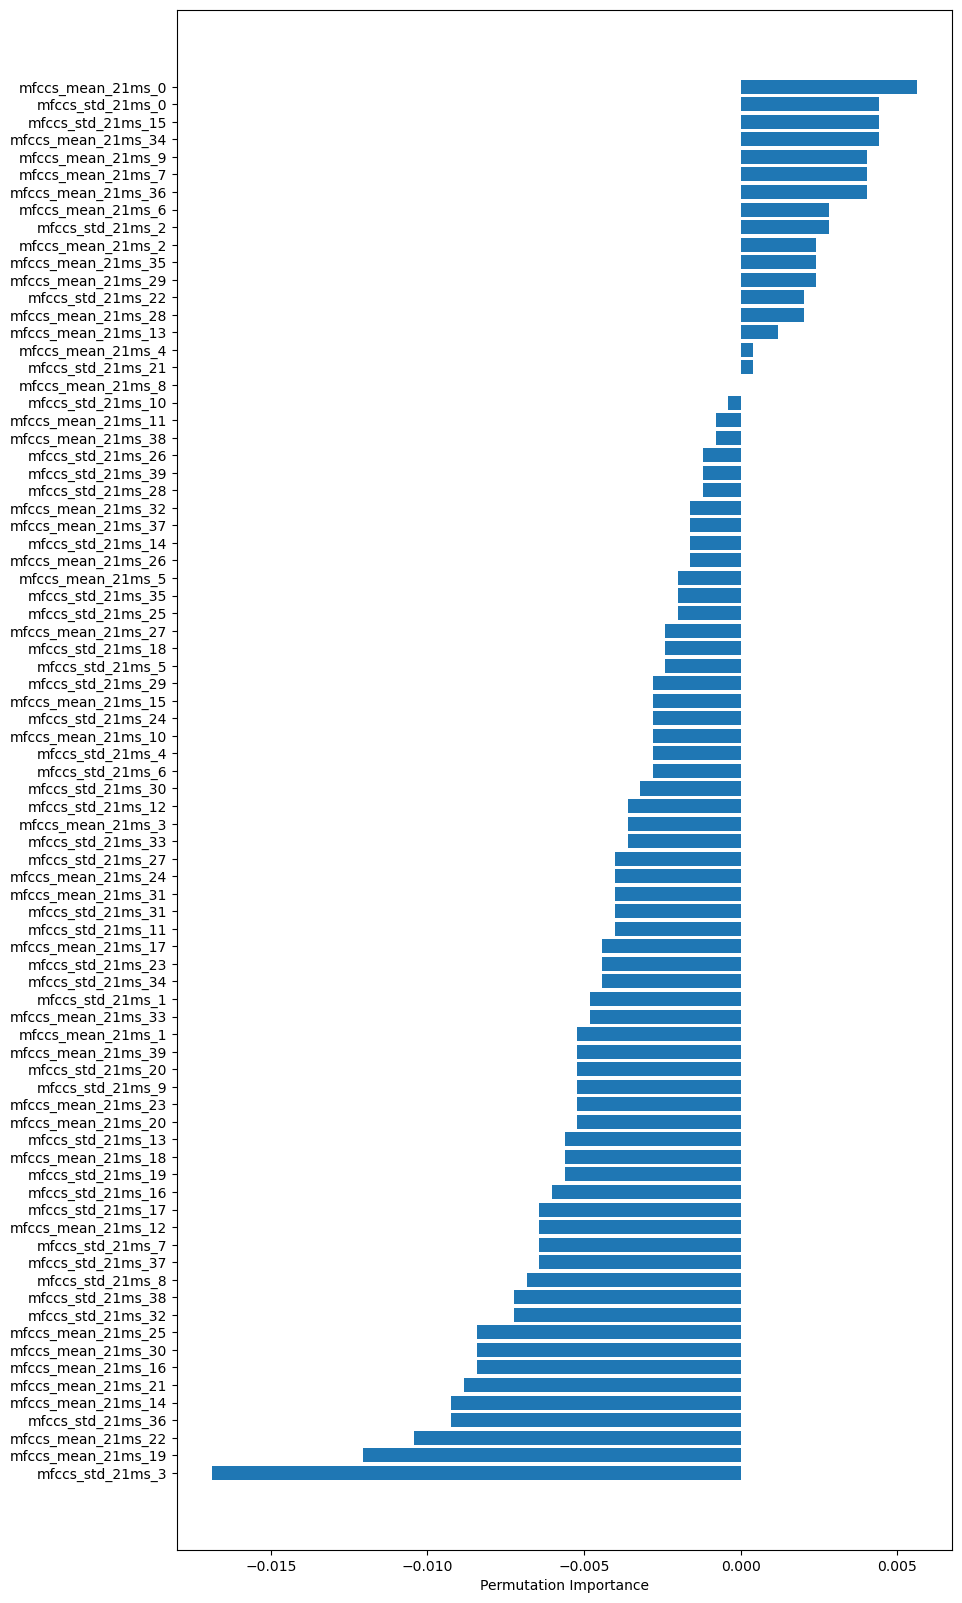

In [64]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

perm_importance = permutation_importance(svm_clf, X_test, y_test)

feature_names = X_train_new.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,20))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")